In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pickle
import sys
import yaml

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, TimeDistributed, Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import plot_model
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import load_model
from sklearn import preprocessing
from copy import deepcopy

import datetime
import math
import hashlib
import time
import os
from datagenerator import DataGenerator

# add
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"  # specify which GPU(s) to be used

Using TensorFlow backend.


In [2]:
#Disable randomization
import random
seed_value=2020 #10 #
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
random.seed(seed_value)

# add
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 
# # sess = tf.Session(config=config) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [3]:
def loadConfig():
#     with open('/home/wesleyjtann/ddos_research/test/light_config_b.yaml', "r") as ymlfile:
    with open('./light_config.yaml', "r") as ymlfile: #GE, hulk, slowhttp, slowloris, heartbleed
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()
# artefact = 'artefact' #'artefact_b' #

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


## Helper functions

In [4]:
def prepare_sentence(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqY = np.append(seq, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    y= pad_sequences([seqY],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    return [x], [y]


def getTokenizer(df) :
    ### Dictionary for Normal ###
    tokenizer = Tokenizer(filters='', split='<sep>', oov_token='<OTHERS>' ,lower=True)
    tokenizer.fit_on_texts(df['Input'].values)

    tokenizer.fit_on_texts(['<SOS>'])
    tokenizer.fit_on_texts(['<EOS>'])

    return tokenizer

# def createGeneratorData(df, tokenizer, max_len) :
#     #Prepare training for normal model
#     x = []
#     y = []

#     for seq in df['Input']:
#         x_windows, y_windows = prepare_sentence(seq, max_len, tokenizer)
#         x += x_windows
#         y += y_windows
#     x = np.array(x)
#     y = np.array(y)  # The word <PAD> does not constitute a class

#     x.shape = [len(x), max_len + 1, 1]
#     y.shape = [len(y), max_len + 1, 1]

#     return x, y

def prepare_sentence_classification(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
#     seqX = np.append(seq, tokenizer.word_index['<eos>'])
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqX = np.append(seqX, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+2,
        padding='post')[0]  # Pads before each sequence

    return [x]


def create_input_data(df, tokenizer, max_len):
    #Prepare training for normal model
    x=[]; y=[]
    for index, row in df.iterrows():
        x_windows = prepare_sentence_classification(row['Input'], max_len, tokenizer)
#         y_labels = row['Label']
        y_labels = row['Attack']
#         x += x_windows
        x.append(x_windows)
        y.append(y_labels)
        
    x = np.array(x)
    y = np.array(y)
#     x.shape = [len(x), max_len+2, 1]
    x = np.reshape(x, (len(x), (max_len+2)))#, 1))

    return x, y

## Loading CAIDA07 dataset

##### Training set

In [5]:
# N1 data
df_normal = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'N1.csv')
print("size of normal data: ", len(df_normal))
# df_normal.head()

size of normal data:  3262


In [6]:
# Entire train atk set. 
df_attackfull = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_full.csv')
print("size of full attack data: ", len(df_attackfull))

size of full attack data:  70286


In [7]:
# make attack 80% of train data 
ratio = 0.5 #0.8 #0.2
df_attacksmall = df_attackfull[-int(len(df_normal)/ratio - len(df_normal)):]
print("size of smaller attack data: ", len(df_attacksmall))

size of smaller attack data:  3262


In [8]:
# add labels for evaluation
df_attacksmall['Attack'] = 1
df_normal['Attack'] = 0

# Join and shuffle train attack and normal data
df_train = df_normal.append(df_attacksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
# df_train =df_normal # df_attacksmall #
print("size of df_train: ", len(df_train))

size of df_train:  6524


/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Test set

In [9]:
df_test = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'TEST.csv')
print("size of df_test: ", len(df_test))

size of df_test:  16310


### Prepare data

In [10]:
max_len = config['SEQUENCELENGTH']

tokenizer = getTokenizer(df_train)  

In [11]:
def prep_modelinputs(df, max_len, tokenizer):
    df_embedded = df.copy()
    df_embedded['Input'] = tokenizer.texts_to_sequences(df['Input'].values)
    # Shuffle the data order
    df_embedded_shuf = df_embedded.sample(frac=1, random_state=42, replace=False)
    # Extract inputs and labels
    X_tmp, y_tmp = create_input_data(df_embedded_shuf, tokenizer, max_len)
    # Convert format for training  
    y_tmp = to_categorical(y_tmp, num_classes=2)
    return X_tmp, y_tmp

In [12]:
X_norm, y_norm = prep_modelinputs(df_normal, max_len, tokenizer)
print(X_norm.shape, y_norm.shape)

(3262, 202) (3262, 2)


In [13]:
X_train, y_train = prep_modelinputs(df_train, max_len, tokenizer)
print(X_train.shape, y_train.shape)

(6524, 202) (6524, 2)


In [14]:
X_test, y_test = prep_modelinputs(df_test, max_len, tokenizer)
print(X_test.shape, y_test.shape)

(16310, 202) (16310, 2)


In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print("Training set, counts of label '0': {}".format(int(np.sum(y_train, axis=0)[0])))
print("Training set, counts of label '1': {}".format(int(np.sum(y_train, axis=0)[1])))
print("Test set, counts of label '0': {}".format(int(np.sum(y_test, axis=0)[0])))
print("Test set, counts of label '1': {}".format(int(np.sum(y_test, axis=0)[1])))

Number transactions X_train dataset:  (6524, 202)
Number transactions y_train dataset:  (6524, 2)
Number transactions X_test dataset:  (16310, 202)
Number transactions y_test dataset:  (16310, 2)
Training set, counts of label '0': 3262
Training set, counts of label '1': 3262
Test set, counts of label '0': 3262
Test set, counts of label '1': 13048


### Model

In [16]:
vocab_size=[len(tokenizer.word_index)] 
input_emb_dim = config['MODELPARAMS']['INPUT_EMBED_DIM'] #512
lstm_emb_dim = config['MODELPARAMS']['LSTM_DIM'] #300
print("vocab_size: ", vocab_size)

vocab_size:  [756]


In [17]:
model = Sequential()
model.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(lstm_emb_dim))
# model.add(TimeDistributed(Dense(2, activation='sigmoid')))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer=optimizers.adam(lr=0.005), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005 config['MODELPARAMS']['LEARNING_RATE_P']

print(model.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 202, 512)          387584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 202, 300)          975600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
Total params: 2,084,986
Trainable params: 2,084,986
Non-trainable params: 0
_________________________________________________________________
None


## Full classifier training

In [18]:
history = model.fit(X_train, y_train, epochs=config['TRAININGPARAMS']['EPOCHS_P'], 
                      batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], validation_split=0.2, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #


Train on 5219 samples, validate on 1305 samples
Epoch 1/30
5219/5219 [==============================] - 10s 2ms/step - loss: 0.6961 - acc: 0.7024 - val_loss: 0.5049 - val_acc: 0.7908
Epoch 2/30
5219/5219 [==============================] - 7s 1ms/step - loss: 0.5345 - acc: 0.7626 - val_loss: 0.5372 - val_acc: 0.7808
Epoch 3/30
5219/5219 [==============================] - 8s 1ms/step - loss: 0.6631 - acc: 0.7271 - val_loss: 0.5516 - val_acc: 0.7889
Epoch 4/30
5219/5219 [==============================] - 8s 1ms/step - loss: 0.5432 - acc: 0.7621 - val_loss: 0.4985 - val_acc: 0.7824
Epoch 5/30
5219/5219 [==============================] - 7s 1ms/step - loss: 0.5239 - acc: 0.7614 - val_loss: 0.4841 - val_acc: 0.8054
Epoch 6/30
5219/5219 [==============================] - 7s 1ms/step - loss: 0.5087 - acc: 0.7704 - val_loss: 0.4817 - val_acc: 0.7943
Epoch 7/30
5219/5219 [==============================] - 8s 2ms/step - loss: 0.4597 - acc: 0.7910 - val_loss: 0.4089 - val_acc: 0.8211
Epoch 8/30
5

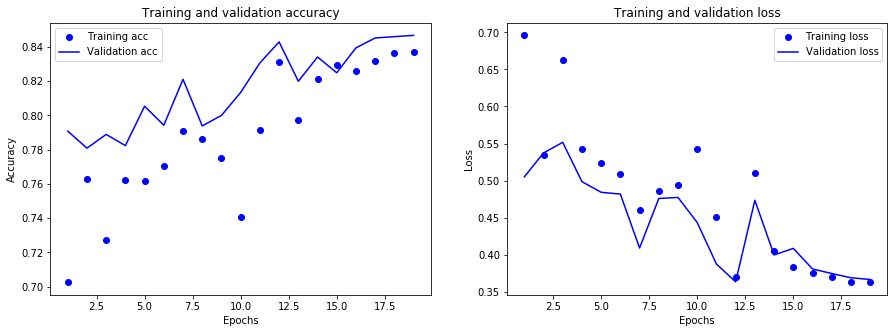

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

f = plt.figure(figsize=(15,5))

ax1 = f.add_subplot(121)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.legend()
ax1.title.set_text('Training and validation accuracy')

ax2 = f.add_subplot(122)
ax2.title.set_text('Generated Synthetic Graph')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

plt.show()

### Evaluate Full classifier model

In [20]:
# Extract true labels
ytest_true = np.argmax(y_test, axis=1)

In [21]:
accr = model.evaluate(X_test, y_test, batch_size=512)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

16310/16310 [==============================] - 6s 394us/step
Test set
  Loss: 0.4422
  Accuracy: 0.7019


In [22]:
y_pred = model.predict_classes(X_test, batch_size=512, verbose=1)

16310/16310 [==============================] - 7s 411us/step


In [23]:
y_predscr = model.predict(X_test, batch_size=512, verbose=1)

predpos = np.count_nonzero(y_predscr[:,1] > 0.5)
pred_allpos = predpos / len(y_predscr)
print('Percentage of Positives: {:0.4f}'.format(pred_allpos))

16310/16310 [==============================] - 6s 392us/step
Percentage of Positives: 0.5093


In [24]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

tn, fp, fn, tp = confusion_matrix(ytest_true, y_pred).ravel()
print(tn, fp, fn, tp)
fpr = fp / (fp+tn)
fpr

Accuracy: 0.7019006744328633
Recall: 0.6319742489270386
Precision: 0.9927763062846136
F1 score: 0.7723143205020137

 clasification report:
               precision    recall  f1-score   support

           0       0.40      0.98      0.57      3262
           1       0.99      0.63      0.77     13048

    accuracy                           0.70     16310
   macro avg       0.70      0.81      0.67     16310
weighted avg       0.87      0.70      0.73     16310


 confusion matrix:
 [[3202   60]
 [4802 8246]]
3202 60 4802 8246


0.018393623543838136

In [25]:
fp_fullclassifier = []    
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for percent in percentages:
    tau_threshold = percent
    ytau_pred = (y_predscr[:,0] < tau_threshold).astype(int)
    tn_tmp, fp_tmp, fn_tmp, tp_tmp = confusion_matrix(ytest_true, ytau_pred).ravel()
    tn_tmp, fp_tmp, fn_tmp, tp_tmp 
    fpr_tmp = fp_tmp / (fp_tmp+tn_tmp)
    fp_fullclassifier.append(fpr_tmp)
    
fp_fullclassifier.insert(0,0)
fp_fullclassifier

[0,
 0.01655426118945432,
 0.017780502759043533,
 0.018393623543838136,
 0.018393623543838136,
 0.018393623543838136,
 0.023911710606989576,
 0.045370938074800735,
 0.7771305947271613,
 0.7771305947271613,
 1.0]

## Iterative classifier training

In [26]:
iter_model = Sequential()
iter_model.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
iter_model.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
iter_model.add(LSTM(lstm_emb_dim))
# model.add(TimeDistributed(Dense(2, activation='sigmoid')))
iter_model.add(Dense(2, activation='sigmoid'))
iter_model.compile(optimizer=optimizers.adam(lr=0.005), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005 config['MODELPARAMS']['LEARNING_RATE_P']

print(iter_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 202, 512)          387584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 202, 300)          975600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 602       
Total params: 2,084,986
Trainable params: 2,084,986
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
X_train, y_train = prep_modelinputs(df_train, max_len, tokenizer)
keep_thres = 0.2 #0.4 # must be <=0.5

for _ in range(5):
    iter_model.fit(X_train, y_train, epochs=3, 
                      batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], validation_split=0.2, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #

    y_predscr = iter_model.predict(X_train, batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], verbose=1)
    
    # Sorting y_predscr and X_train
    sorting = np.argsort(-1*y_predscr[:, 1]) # add (-1*) to argsort the second column in descending order 
    ypred_sorted = y_predscr[sorting] 
    Xtrain_sorted = X_train[sorting]
    
    # reduce Xtrain_sorted and ypred_sorted to keep_num size
    keep_num = int(len(y_predscr)*keep_thres)
    Xtrain_atk = Xtrain_sorted[:keep_num,:]
    ytrain_atk = np.vstack((np.zeros(keep_num), np.ones(keep_num))).T #.shape
    
    # randomly choose from X_norm to create new training set
    Xtrain_norm = X_norm[np.random.choice(X_norm.shape[0], size=keep_num, replace=False), :]
    X_train = np.concatenate((Xtrain_atk,Xtrain_norm), axis=0)
    y_train = np.concatenate((ytrain_atk,y_norm[:len(Xtrain_norm)]), axis=0)
    
    # Shuffle new training set
    shuffler = np.random.permutation(len(X_train))
    X_train = X_train[shuffler]
    y_train = y_train[shuffler]

Train on 5219 samples, validate on 1305 samples
Epoch 1/3
5219/5219 [==============================] - 8s 2ms/step - loss: 0.7406 - acc: 0.6815 - val_loss: 0.5505 - val_acc: 0.7563
Epoch 2/3
5219/5219 [==============================] - 8s 1ms/step - loss: 0.5697 - acc: 0.7382 - val_loss: 0.5451 - val_acc: 0.7563
Epoch 3/3
6524/6524 [==============================] - 3s 398us/step
Train on 2086 samples, validate on 522 samples
Epoch 1/3
2086/2086 [==============================] - 4s 2ms/step - loss: 0.3427 - acc: 0.9391 - val_loss: 0.2729 - val_acc: 0.9368
Epoch 2/3
2086/2086 [==============================] - 4s 2ms/step - loss: 0.2480 - acc: 0.9391 - val_loss: 0.2161 - val_acc: 0.9368
Epoch 3/3
2608/2608 [==============================] - 1s 439us/step
Train on 833 samples, validate on 209 samples
Epoch 1/3
833/833 [==============================] - 1s 2ms/step - loss: 0.1313 - acc: 0.9544 - val_loss: 0.1026 - val_acc: 0.9569
Epoch 2/3
833/833 [==============================] - 1s 2m

In [27]:
X_train.shape

(2136, 202)

### Evaluate Iterative classifier model

In [35]:
# Extract true labels
ytest_true = np.argmax(y_test, axis=1)

In [36]:
accr = iter_model.evaluate(X_test, y_test, batch_size=512)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

16310/16310 [==============================] - 6s 395us/step
Test set
  Loss: 2.1448
  Accuracy: 0.5801


In [37]:
y_pred = iter_model.predict_classes(X_test, batch_size=512, verbose=1)

16310/16310 [==============================] - 6s 392us/step


In [38]:
y_predscr = iter_model.predict(X_test, batch_size=512, verbose=1)

predpos = np.count_nonzero(y_predscr[:,1] > 0.5)
pred_allpos = predpos / len(y_predscr)
print('Percentage of Positives: {:0.4f}'.format(pred_allpos))

16310/16310 [==============================] - 6s 393us/step
Percentage of Positives: 0.3914


In [39]:
# lr = 0.005
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

tn, fp, fn, tp = confusion_matrix(ytest_true, y_pred).ravel()
print(tn, fp, fn, tp)
fpr = fp / (fp+tn)
fpr

Accuracy: 0.5801348865726548
Recall: 0.4822194972409565
Precision: 0.9855889724310777
F1 score: 0.6475916014820914

 clasification report:
               precision    recall  f1-score   support

           0       0.32      0.97      0.48      3262
           1       0.99      0.48      0.65     13048

    accuracy                           0.58     16310
   macro avg       0.65      0.73      0.56     16310
weighted avg       0.85      0.58      0.61     16310


 confusion matrix:
 [[3170   92]
 [6756 6292]]
3170 92 6756 6292


0.028203556100551808

In [40]:
fp_classifier = []    
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for percent in percentages:
    tau_threshold = percent
    ytau_pred = (y_predscr[:,0] < tau_threshold).astype(int)
    tn_tmp, fp_tmp, fn_tmp, tp_tmp = confusion_matrix(ytest_true, ytau_pred).ravel()
    tn_tmp, fp_tmp, fn_tmp, tp_tmp 
    fpr_tmp = fp_tmp / (fp_tmp+tn_tmp)
    fp_classifier.append(fpr_tmp)
    
fp_classifier.insert(0,0)
fp_classifier

[0,
 0.0269773145309626,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.028203556100551808,
 0.029429797670141016,
 0.029429797670141016,
 0.029429797670141016,
 1.0]

16310


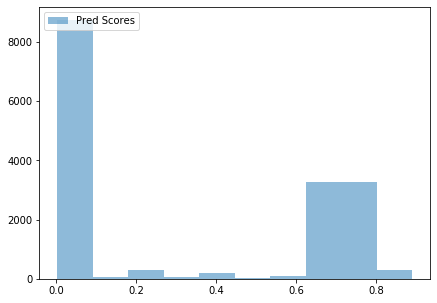

In [34]:
import matplotlib.pyplot as plt

scores = y_predscr[:,1] # classifier atk scores
# def showscore(scores):
fig = plt.figure(figsize=(7,5))
print(len(scores))
plt.hist(scores, bins = 10, alpha=0.5, label='Pred Scores') 
#     plt.hist(scoretype[scores][scoretype['Attack'] == 1], bins = 10, alpha=0.5, label='attacker')
plt.legend(loc='upper left')
plt.show()
    
# showscore(y_predscr) # P scores